In [1]:
import numpy as np
import cv2
import glob
import sys
import argparse
from matplotlib import pyplot as plt
import cv2 as cv
import time
from numpy.linalg import inv

In [2]:
def undistorth(img,mtx,dist):#function for un distorting the image wrt to camera parameters 
                             #obtained from camera calibration
        h,w = img.shape[:2]
        newcameramtx,roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h)) 
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
        return dst

In [3]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([105,60,50])
    upper = np.array([125,110,115])
    yellower = np.array([255,215,0]) 
    yelupper = np.array([50,255,255])
    yellowmask = cv2.inRange(hls, yellower, yelupper)
    whitemask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellowmask, whitemask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [4]:
def roi(img):   # function to get region of interest in a image
    x = int(img.shape[1])
    y = int(img.shape[0])
    #change the ppoly coordinate according the camera mount
    shape = np.array([[0,250],[640,250],[640,480],[0,480]])
    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)
    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)
    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def birdeyeview(frame):
    #cv2.circle(frame, (155, 280), 5, (0, 0, 255), -1)
    #cv2.circle(frame, (500, 280), 5, (0, 0, 255), -1)
    #cv2.circle(frame, (5, 435), 5, (0, 0, 255), -1)
    #cv2.circle(frame, (605, 435), 5, (0, 0, 255), -1)
    pts1 = np.float32([[155, 280],[500, 280],[605, 435],[5,435]])
    pts2 = np.float32([[0, 0], [605, 0],[605,440],[0,440]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(frame, matrix, (605,440))
    return result,matrix

In [6]:
def extract_lanes_pixels(binary_warped):

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        #plt.plot(histogram)
        #plt.show()
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds

def poly_fit(leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, binary_warped, plot:False):  

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        if(plot):
            plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 640)
            plt.ylim(540, 0)
            plt.show()

        return left_fit, right_fit, ploty, left_fitx, right_fitx

In [7]:
def compute_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty):
 
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
 
        y_eval = np.max(ploty)
 
        fit_cr_left = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
        curverad_left = ((1 + (2 * left_fit[0] * y_eval / 2. + fit_cr_left[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr_left[0])
        fit_cr_right = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
        curverad_right = ((1 + (2 * left_fit[0] * y_eval / 2. + fit_cr_right[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr_right[0])
        return (curverad_left + curverad_right) / 2

In [9]:
 def compute_center_offset(curverad, undist_image, plot=False):
        xm_per_pix = 3.7/700
        lane_center_x = int(curverad)
        image_center_x = int(undist_image.shape[1] / 2)
        offset_from_centre = (image_center_x - lane_center_x) * xm_per_pix # in meters
        return offset_from_centre

In [8]:
def pain_lane(undist, warped, M, left_fitx, right_fitx, ploty, plot=False):
        
        Minv = inv (M)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
        #newwarp=undistorth(newwarp)
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        if(plot):
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            
        
        return result

In [10]:
 def render_curvature_and_offset(rundist_image, curverad, offset, plot=False):   
        # Add curvature and offset information
        offst_text = 'offset: {:.2f}m'.format(offset)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(rundist_image, offst_text, (24, 50), font, 1, (255, 255, 255), 2)
        curverad_text = 'curverad: {:.2f}m'.format(curverad)
        cv2.putText(rundist_image, curverad_text, (19, 90), font, 1, (255, 255, 255), 2)
        if(plot):
            plt.imshow(cv2.cvtColor(rundist_image, cv2.COLOR_BGR2RGB))
        return rundist_image

/home/karthik/anaconda3/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  after removing the cwd from sys.path.


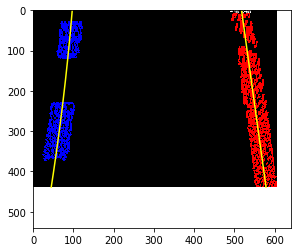

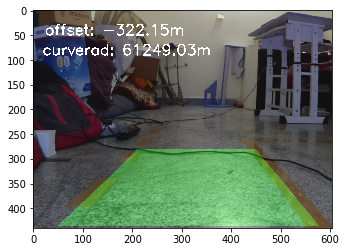

In [12]:
mtx=np.loadtxt('/home/karthik/Downloads/opencv/camera_01/cameraMatrix.txt', delimiter=',', dtype=None)
dist=np.loadtxt('/home/karthik/Downloads/opencv/camera_01/cameraDistortion.txt', delimiter=',', dtype=None)
img = cv2.imread('/home/karthik/Downloads/opencv/camera_01/prueb177.jpg')
undisimage=undistorth(img,mtx,dist)
maskedimage=color_filter(undisimage)
roiimage=roi(maskedimage)
greyimage=cv2.cvtColor(roiimage, cv2.COLOR_RGB2GRAY)
cannyimage=cv2.Canny(greyimage,100 ,80)
birdviewimage,matrix=birdeyeview(cannyimage)
plot=True
leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds=extract_lanes_pixels(birdviewimage)
left_fit, right_fit, ploty, left_fitx, right_fitx=poly_fit( leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, birdviewimage,plot)
curvature=compute_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty)
new_image=pain_lane(undisimage, birdviewimage, matrix, left_fitx, right_fitx, ploty, plot)
inputinmage=new_image
offset_from_centre=compute_center_offset(curvature, new_image, plot)
new_image=render_curvature_and_offset(inputinmage, curvature, offset_from_centre, plot)





In [111]:
img = cv2.imread('/home/karthik/Downloads/opencv/camera_01/prueb178.jpg')
undisimage=undistorth(img,mtx,dist)
colorwarp=birdeyeview(undisimage)

 